<div style="font-family:verdana;font-size:3.5rem;text-align:center;">
    BERTopic Tutorial : Topic Modeling For <br/> Articles Abstracts
</div>

<h1 style="font-family:verdana;">Overview</h1>

- [Preliminaries](#preliminaries)
- [Necessary Packages](#necessary_packages)
- [Load The Dataset](#load_data)
- [Apply The Model - Unsupervised](#unsup)
- [Apply The Model - Semi-supervised / Guided](#semi-sup)
- [Acknowledgement](#ack)
- [Conclusion](#conclusion)

<div id="preliminaries" >
    <h1 style="font-family:verdana;">Preliminaries</h1>
</div>

### What is Topic Modeling ?

**Topic Modeling** is a task of **Natural Language Processing (NLP)** that aims at identiying relevant topics / categories / themes from a collection of documents. In this notebook we will explore **BERTopic** a method that leverages deep-pretrained language models embeddings for the task of **Topic Modeling** and we will using [Research Articles Dataset](#https://www.kaggle.com/datasets/fellahabdelnour13/articles-classification-dataset).

### What is Sentence-BERT ?

**Sentence-BERT** is a language model based on **BERT** which is in tunr based on the transformer architecture, as its name suggests it is used to obtain <br/> **sentence-level embeddings**. It is basically a pre-trained BERT **fine-tuned** in a **siamese networks** fashion to predict similarities between sentences.

<p align="center">
    <img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/SBERT.jpeg" />
</p>

[An Intuitive Explanation of Sentence-BERT, Towards Data Science](#https://towardsdatascience.com/an-intuitive-explanation-of-sentence-bert-1984d144a868/)

### How do BERTopic Work ?

**BERTopic** is not an end-to-end model-like BERT but rather a pipeline that laverages pre-trained **SentenceTransofmers (like SentenceBERT)** in one its step, it is composed of **six steps** : 

1. **Obtaining Documents Embeddings** : Usually **SentenceBERT** (SBERT) is used.
2. **Dimentiality Reduction** : Usually **UMAP** is used to reduce the number of features.
3. **Clustering** : Dividing the corpus into a set of clusters, **HDBSCAN** is used by default.
4. **Tokenization** : In this step the documents belonging to the same cluster are combained into ona large-document then **bag-of-words** technique is used <br/> to compute **cluster-level representations**.
5. **c-TF-IDF** : Apply **TF-IDF** to re-weight the cluster-level representations. these weights will represent **words** importances in a cluster.
6. **Fine Tuning (Optional)** : Further Fine Tuning to enhance the results, many options are available.

<p align="center" >
    <img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/BERTopic.svg" style="background-color: white; padding: 16px;" />
</p>

[BERTopic](#https://maartengr.github.io/BERTopic/algorithm/algorithm.html)

<div id="necessary_packages" >
    <h1 style="font-family:verdana;">Necessary Packages</h1>
</div>

In [1]:
!pip install bertopic --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import display, Markdown
from bertopic import BERTopic
from wordcloud import WordCloud

2025-10-20 14:33:35.717396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760970815.894498      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760970815.951172      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
px.defaults.template = "seaborn"

<div id="load_data" >
    <h1 style="font-family:verdana;">Load The Dataset</h1>
</div>

In [4]:
DATA_DIR = os.path.join('/kaggle/input/articles-classification-dataset')

In [5]:
data = pd.read_json(os.path.join(DATA_DIR, "data.raw.json"))

In [6]:
sample = data.iloc[0].to_dict()
sample['date'] = str(sample['date'])

display(Markdown(f"""```json
    {json.dumps(sample, indent=4)}
```"""))

```json
    {
    "id": 5096000,
    "title": "Diffusion-based spectral super-resolution of third octave acoustic sensor data: is privacy at risk ?",
    "abstract": "Third octave spectral recording of acoustic sensor data is an effective way of measuring the environment. While there is strong evidence that slow (1s frame, 1 Hz rate) and fast (125ms frame, 8Hz rate) versions lead by-design to unintelligible speech if reconstructed, the advent of high quality reconstruction methods based on diffusion may pose a threat, as those approaches can embed a significant amount of a priori knowledge when learned over extensive speech datasets.<p>This paper aims to assess this risk at three levels of attacks with a growing level of a priori knowledge considered at the learning of the diffusion model, a) none, b) multi-speaker data excluding the target speaker and c) target speaker. Without any prior regarding the speech profile of the speaker (levels a and b), our results suggest a rather low risk as the worderror-rate both for humans and automatic recognition remains higher than 89%.</p>",
    "keywords": [
        "speech privacy",
        "generative audio",
        "acoustic sensor networks",
        "audio encoding"
    ],
    "authors": [
        "Modan Tailleur",
        "Chaymae Benaatia",
        "Mathieu Lagrange",
        "Pierre Aumond",
        "Vincent Tourre"
    ],
    "venue": [
        "info.info-ai"
    ],
    "date": "2025-09-08 00:00:00+00:00",
    "teams": [
        "AAU",
        "LS2N"
    ]
}
```

<div id="unsup" >
    <h1 style="font-family:verdana;">Apply The Model - Unsupervised</h1>
</div>

## Run The Model

In [7]:
model = BERTopic()

In [8]:
topics, probs = model.fit_transform(data["abstract"].to_list())
topics = np.array(topics)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Visualize The Results

In [9]:
topics_df = model.get_topic_info()
topics_df.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5718,-1_the_and_of_to,"[the, and, of, to, in, for, is, this, on, by]",[Constraint Programming is an optimization tec...
1,0,357,0_food_strains_meat_monocytogenes,"[food, strains, meat, monocytogenes, spoilage,...","[Food products can be spoiled by bacteria, as ..."
2,1,205,1_cloud_computing_infrastructures_infrastructure,"[cloud, computing, infrastructures, infrastruc...",[As a direct consequence of the increasing pop...
3,2,198,2_urban_ambiances_spaces_city,"[urban, ambiances, spaces, city, atmospheres, ...",[Research on architectural and urban atmospher...
4,3,180,3_flow_heat_wall_velocity,"[flow, heat, wall, velocity, vortex, fluid, tr...","[In this paper, we investigate the effects of ..."


In [10]:
print(f"There is {len(topics_df) - 1} topics.")

There is 443 topics.


### Select A Random Topic To Visualize

In [11]:
topic = 0

- Title

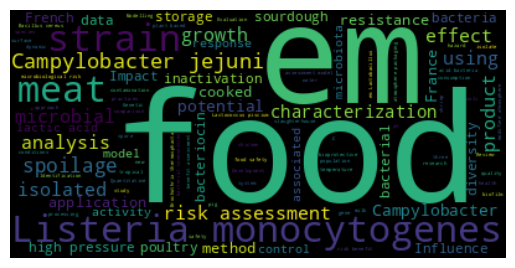

In [12]:
text = ' '.join(data[topics == topic].title)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Abstract

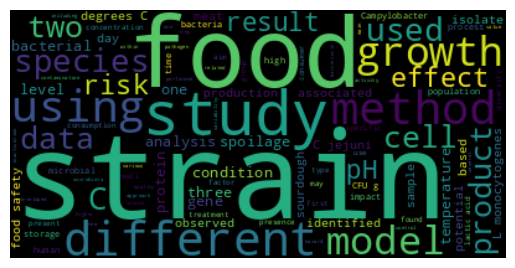

In [13]:
text = ' '.join(data[topics == topic].abstract)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Keywords

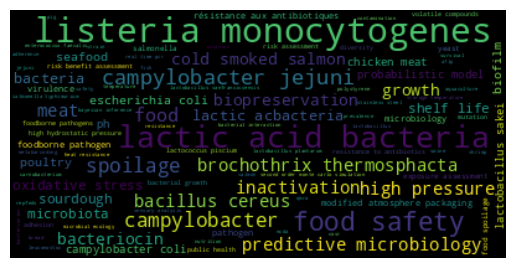

In [14]:
keywords = pd.Series(data[topics == topic]['keywords'].agg(sum)).value_counts().to_dict()

wordcloud = WordCloud().generate_from_frequencies(keywords)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
fig = px.bar(
    data_frame = pd.Series(keywords)
        .reset_index()
        .rename(columns={ "index" : "Keyword", 0 : "Frequency" })
        .nlargest(15, "Frequency")
        .sort_values(by = "Frequency"),
    x = "Frequency",
    y = "Keyword",
    width = 800,
    height = 550
)

fig.show()

- Venues

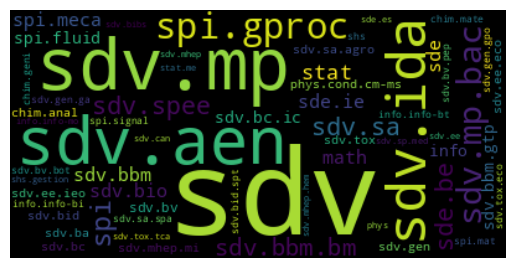

In [16]:
venues = pd.Series(data[topics == topic]['venue'].agg(sum)).value_counts().to_dict()

wordcloud = WordCloud().generate_from_frequencies(venues)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<div id="semi-sup" >
    <h1 style="font-family:verdana;">Apply The Model - Semi-supervised / Guided</h1>
</div>

## Load The Topics

In [17]:
topic_seeds = pd.read_csv(os.path.join(DATA_DIR, "topics.csv"))
topic_seeds.head()

,Unnamed: 0,name,keywords
0,0,Robotics,"['robot', 'robotic', 'automation', 'cobot', 'e..."
1,1,Processes and Assembly,"['assembly', 'welding', 'bonding', 'machining'..."
2,2,Additive Manufacturing,"['FDM', 'SLA', 'SLS', 'SLM', 'DMLS', 'EBM', 'l..."
3,3,Monitoring and Analysis,"['sensor', 'SCADA', 'IIoT', 'OEE', 'optimizati..."
4,4,Eco-design,"['eco-design', 'LCA', 'cradle-to-cradle', 'bio..."


In [18]:
def str2list(arg : str) -> list[str]:

    arg = arg[1:-1]
    words = arg.split(', ')
    words = list(map(lambda x : x[1:-1], words))

    return words

In [19]:
topic_seeds["keywords"] = topic_seeds["keywords"].apply(str2list)
seeds = topic_seeds["keywords"].tolist()

## Run The Model

In [20]:
topic_model = BERTopic(seed_topic_list=seeds)

In [21]:
topics, probs = topic_model.fit_transform(data["abstract"].to_list())
topics = np.array(topics)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 19483719-62ff-4703-8988-9e7b468e26f7)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/sentence_bert_config.json
Retrying in 1s [Retry 1/5].


## Visualize The Results

In [22]:
topics_df = topic_model.get_topic_info()
topics_df.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6295,-1_and_the_to_of,"[and, the, to, of, in, for, is, on, this, by]","[During the last century, most of the meaningf..."
1,0,232,0_parallel_manipulator_workspace_manipulators,"[parallel, manipulator, workspace, manipulator...",[This paper deals with the non-singular assemb...
2,1,206,1_innovation_smes_organizational_product,"[innovation, smes, organizational, product, fi...",[Small businesses face multiple constraints on...
3,2,170,2_constraint_constraints_search_problems,"[constraint, constraints, search, problems, pr...","[During the last two decades, Constraint Progr..."
4,3,168,3_dyes_fluorescence_emission_esipt,"[dyes, fluorescence, emission, esipt, intramol...",[Dual-state emissive (DSE) fluorophores are or...


In [23]:
print(f"There is {len(topics_df) - 1} topics.")

There is 411 topics.


### Select A Random Topic To Visualize

In [24]:
topic = 20

- Title

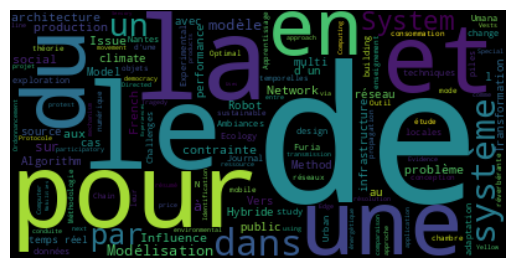

In [25]:
text = ' '.join(data[topics == topic].title)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Abstract

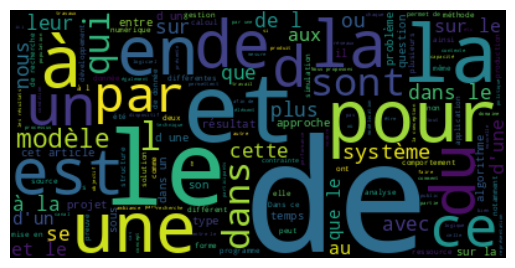

In [26]:
text = ' '.join(data[topics == topic].abstract)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Keywords

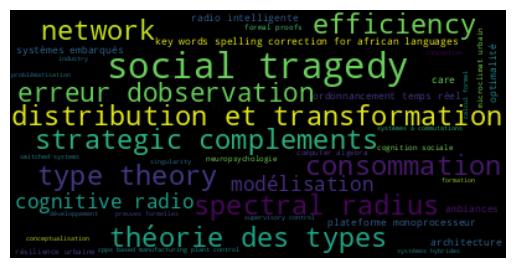

In [27]:
keywords = pd.Series(data[topics == topic]['keywords'].agg(sum)).value_counts().to_dict()

wordcloud = WordCloud().generate_from_frequencies(keywords)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
fig = px.bar(
    data_frame = pd.Series(keywords)
        .reset_index()
        .rename(columns={ "index" : "Keyword", 0 : "Frequency" })
        .nlargest(15, "Frequency")
        .sort_values(by = "Frequency"),
    x = "Frequency",
    y = "Keyword",
    width = 800,
    height = 550
)

fig.show()

- Venues

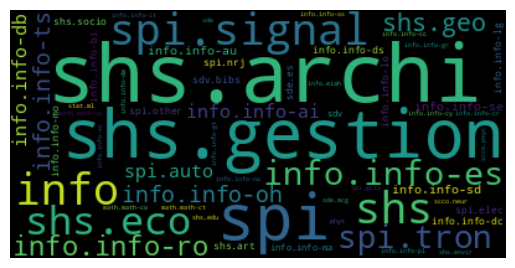

In [29]:
venues = pd.Series(data[topics == topic]['venue'].agg(sum)).value_counts().to_dict()

wordcloud = WordCloud().generate_from_frequencies(venues)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<div id="ack" >
    <h1 style="font-family:verdana;">Acknowledgement</h1>
</div>

- [BERTopic | Official Page](#https://maartengr.github.io/BERTopic/index.html)
- [BERTopic for Topic Modeling - Maarten Grootendorst - Talking Language AI Ep#1](#https://www.youtube.com/watch?v=uZxQz87lb84)
- [An Intuitive Explanation of Sentence-BERT | by Saketh Kotamraju | Towards Data Science](#https://towardsdatascience.com/an-intuitive-explanation-of-sentence-bert-1984d144a868/)

<div id="conclusion">
    <p style="font-family:verdana;font-size:2.5rem">Thank You :)</p>
</div>